In [8]:
import logging
from pathlib import Path
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from dataset.data_loading import BasicDataset
from dataset.dataset_interface import DatasetInterface
from networks.UNet.unet_model import UNet
import open3d as o3d
from utils.visualization_utils import visualize_depth, to_rgb
from utils.transformation_utils import imgs_to_pcd, rs_ci
import yaml

root_path = Path("../")

class Args:
    model_dir = root_path / "resources/models/1644866870.5663009/M_total"
    input_augmented = root_path / "resources/images/calibrated_masked_augmented/cropped/ycb_video/test_dataset.json"
    input_not_augmented = root_path / "resources/images/calibrated_masked/cropped/ycb_video/test_dataset.json"

args = Args()

config_path = args.model_dir.parent / "config.yml"
model = sorted(args.model_dir.glob("*.pth"))[-1]
with open(config_path) as f:
    config = yaml.safe_load(f)

network_config = config['network_config']
trainer_config = config['basic_trainer']
dataset_config = config['dataset_config']

if 'augmented' in trainer_config['train_path']:
    files = DatasetInterface.get_files_by_path(args.input_augmented)
else:
    files = DatasetInterface.get_files_by_path(args.input_not_augmented)

net = UNet(n_input_channels=6, n_output_channels=1, initial_channels=network_config['initial_channels'])
net = nn.DataParallel(net)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Loading model {model}')
logging.info(f'Using device {device}')

net.to(device=device)
net.load_state_dict(torch.load(model, map_location=device))
net.eval()

logging.info('Model loaded!')


INFO - 2022-02-15 23:55:24,429 - 2599306270 - Loading model ../resources/models/1644866870.5663009/M_total/e2.pth
INFO - 2022-02-15 23:55:24,430 - 2599306270 - Using device cpu
INFO - 2022-02-15 23:55:24,460 - 2599306270 - Model loaded!


INFO - 2022-02-15 23:55:41,138 - 785045084 - 
Predicting image /home/claudiusk/Documents/Studium/KIT/Master/Semester_1/DL_Praktikum/self-supervised-depth-denoising/resources/images/calibrated_masked_augmented/cropped/ycb_video/10022022/1644492608.9320533_22.npz ...


426.40128 1139.5912
Mean depths: Input 56.62882137345679Label 0.08932127803564072 Predicted 916.060546875


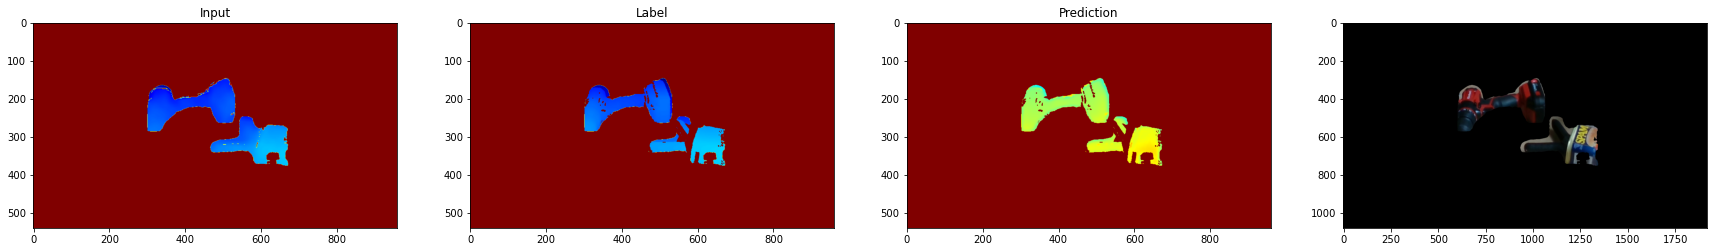

In [10]:
idx = np.random.randint(len(files), size=1).item()

# files = "/home/claudiusk/Documents/Studium/KIT/Master/Semester_1/DL_Praktikum/self-supervised-depth-denoising/resources/images/calibrated_masked_augmented/cropped/ycb_video/10022022/1644494193.0800986_3.npz"

rs_rgb, rs_depth, zv_rgb, zv_depth, mask = DatasetInterface.load(files[idx])

logging.info(f'\nPredicting image {files[idx]} ...')

rs_min = np.nanmin(rs_depth)
rs_max = np.nanmax(rs_depth)

set = BasicDataset.preprocess_set(
    rs_rgb, 
    rs_depth, 
    mask, 
    zv_depth, 
    dataset_config=BasicDataset.Config(
        scale=dataset_config['scale_images'], 
        enable_augmentation=dataset_config['enable_augmentation'], 
        add_nan_mask_to_input=dataset_config['add_nan_mask_to_input'], 
        add_region_mask_to_input=dataset_config['add_region_mask_to_input'], 
        normalize_depths=dataset_config['normalize_depths']
    )
)

img = set['image'].unsqueeze(0)
nan_mask = set['nan-mask'] 
region_mask = set['region-mask']
img = img.to(device=device, dtype=torch.float32)

with torch.no_grad():
    pred_depths = net(img)
    pred_depth = pred_depths.squeeze().float().cpu().detach().numpy()

# blackout pixel not in mask
print(np.nanmin(pred_depth), np.nanmax(pred_depth))
pred_depth = np.where(np.logical_and(nan_mask, region_mask)[0], pred_depth, np.nan)

# undo normalization
if dataset_config['normalize_depths']:
    pred_depth = pred_depth * (rs_max - rs_min) + rs_min

input_rgb = BasicDataset.resize(rs_rgb, dataset_config['scale_images'])
output_rgb = BasicDataset.resize(zv_rgb, dataset_config['scale_images'])
input_depth = BasicDataset.resize(rs_depth, dataset_config['scale_images'])
real_depth = BasicDataset.resize(zv_depth, dataset_config['scale_images'])

# real_depth = np.nan_to_num(real_depth)
# input_depth = np.nan_to_num(input_depth)

print(f"Mean depths: Input {np.nanmean(input_depth)}\
Label {np.nanmean(real_depth)} Predicted {np.nanmean(pred_depth)}")

pred_pcd = imgs_to_pcd(input_rgb, pred_depth, rs_ci)
input_pcd = imgs_to_pcd(input_rgb, input_depth.astype(np.float32), rs_ci)
output_pcd = imgs_to_pcd(output_rgb, real_depth, rs_ci)
o3d.visualization.draw_geometries([input_pcd])
o3d.visualization.draw_geometries([pred_pcd])

_, axarr = plt.subplots(1, 4, figsize=(30, 10))
axarr[0].title.set_text("Input")
axarr[0].imshow(visualize_depth(input_depth))
axarr[1].title.set_text("Label")
axarr[1].imshow(visualize_depth(real_depth))
axarr[2].title.set_text("Prediction")
axarr[2].imshow(visualize_depth(pred_depth))
axarr[3].imshow(to_rgb(rs_rgb))